In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, make_scorer
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Step 1. Open the data file and study the general information.

| Column Name               | Description                                                               |
|---------------------------|---------------------------------------------------------------------------|
| Pregnancies               | Number of times pregnant                                                  |
| Glucose                   | Plasma glucose concentration a 2 hours in an oral glucose tolerance test  |
| BloodPressure             | Diastolic blood pressure (mm Hg)                                          |
| SkinThickness             | Triceps skin fold thickness (mm)                                          |
| Insulin                   | 2-Hour serum insulin (mu U/ml)                                            |
| BMI                       | Body mass index (weight in kg/(height in m)^2)                            |
| DiabetesPedigreeFunction  | Diabetes pedigree function                                                |
| Age                       | Age (years)                                                               |
| Outcome                   | Class variable (0 or 1) 268 of 768 are 1, the others are 0                |


In [2]:
df = pd.read_csv("datasets/diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
from mymodule import check_df, find_categorical_columns, binary_columns_find


In [5]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Duplicate Values #####################
0
##################### NA #####################
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


## Step 2. Prepare the data

In [7]:
categorical_columns=find_categorical_columns(df)

In [8]:
categorical_columns

['Outcome']

In [9]:
numerical_columns = [col for col in df.columns if df[col].dtypes in ["int","float", 'int64']]
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

In [10]:
numerical_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [11]:
binary_columns=binary_columns_find(df)
binary_columns

['Outcome']

## Step 3. Analyze the data

### Correlation 

In [12]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


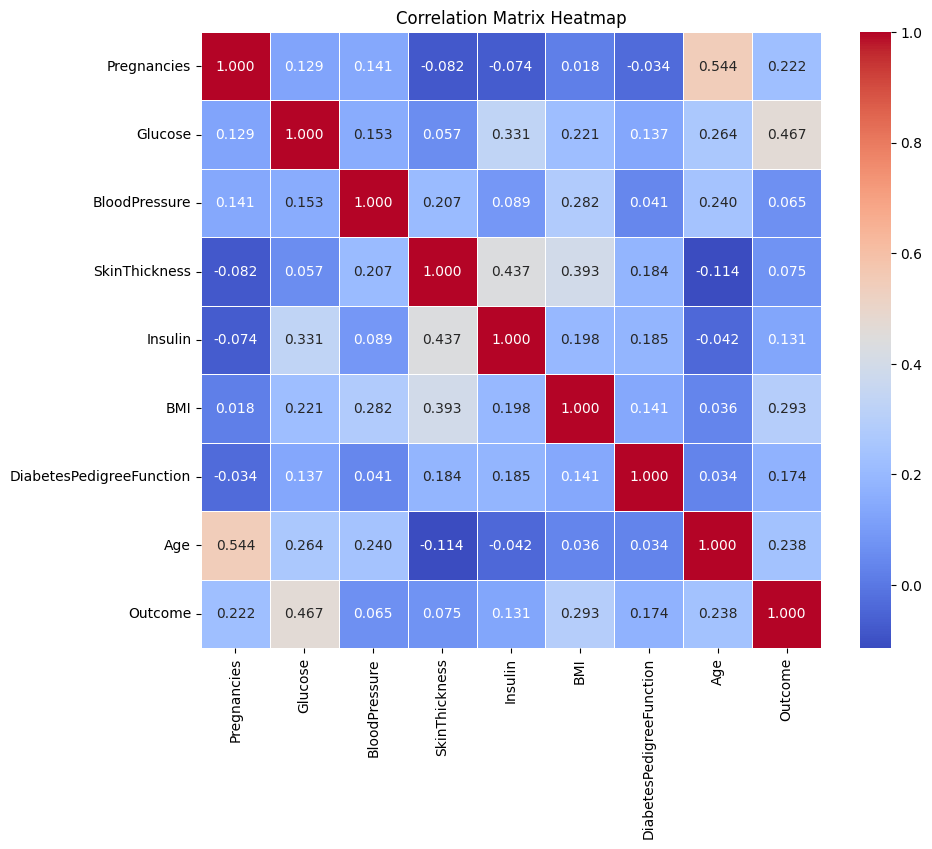

In [13]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [14]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [15]:
high_correlated_cols(df)

[]

In [16]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Analyze the target value

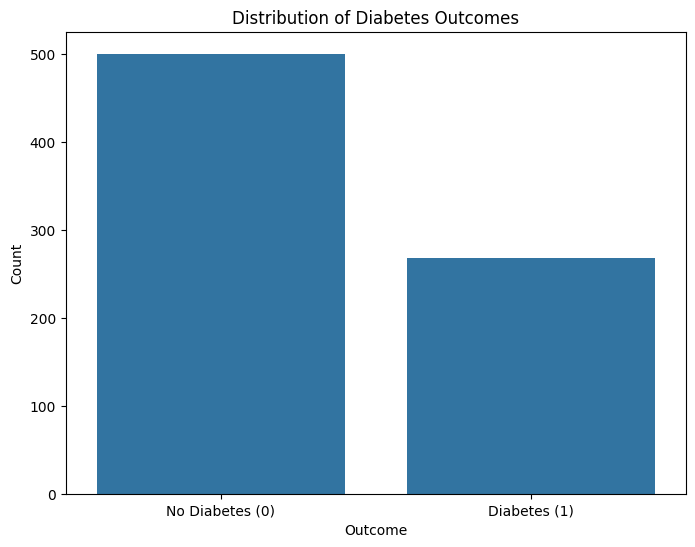

In [17]:
outcome_counts = df['Outcome'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.show()


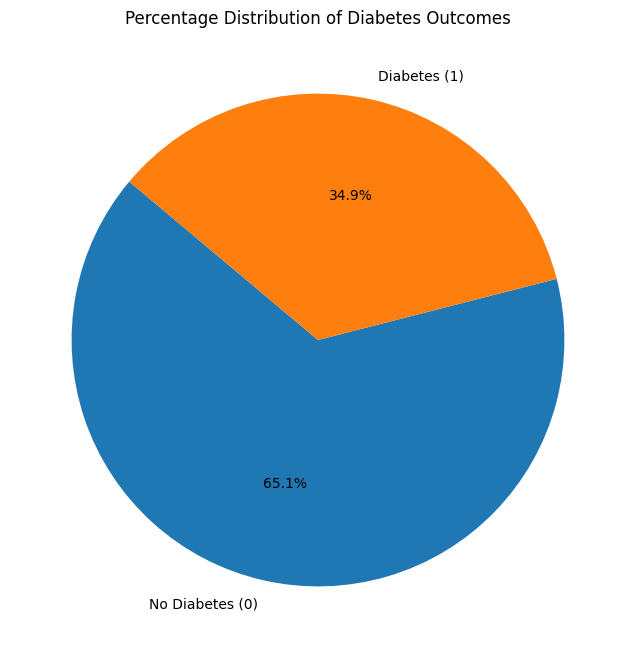

In [18]:
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=['No Diabetes (0)', 'Diabetes (1)'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Diabetes Outcomes')
plt.show()

##  Box plot

A box plot can be used to analyze the correlation and study the target value

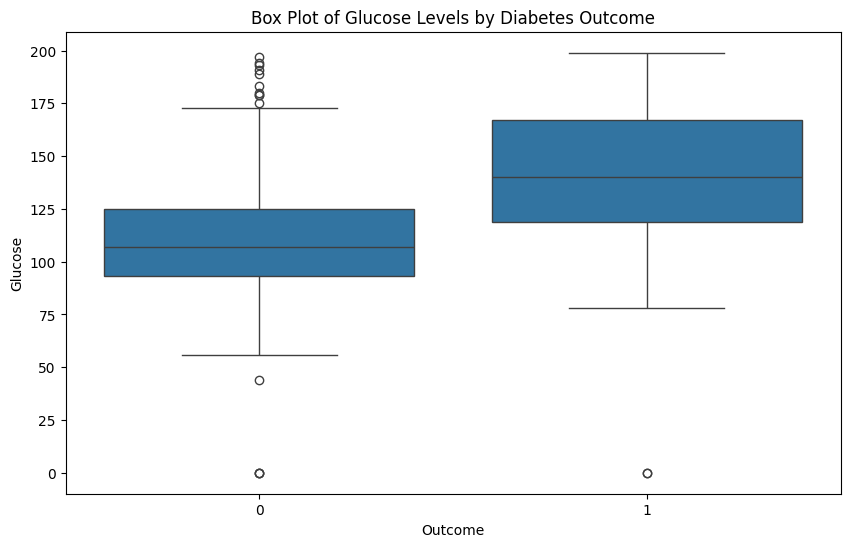

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Box Plot of Glucose Levels by Diabetes Outcome')
plt.xlabel('Outcome')
plt.ylabel('Glucose')
plt.show()


## Violin plot

Additionally, a violin plot could be used

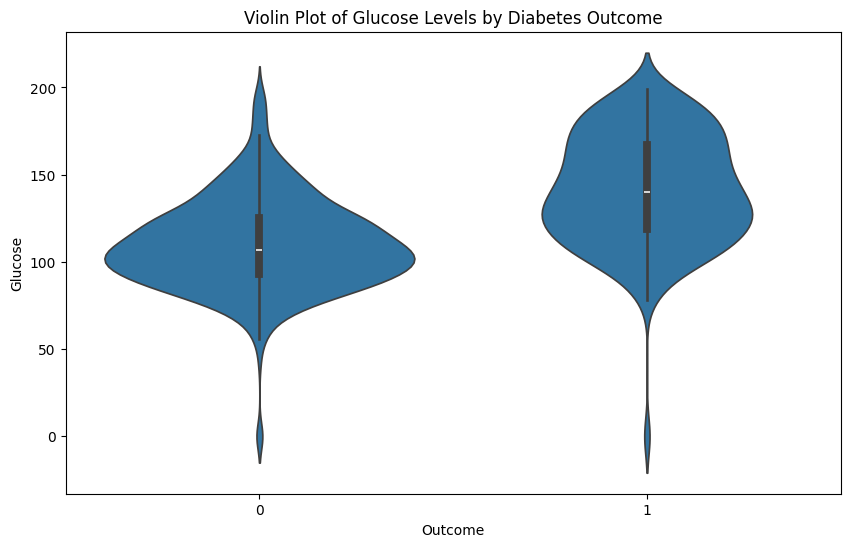

In [20]:


plt.figure(figsize=(10, 6))
sns.violinplot(x='Outcome', y='Glucose', data=df)
plt.title('Violin Plot of Glucose Levels by Diabetes Outcome')
plt.xlabel('Outcome')
plt.ylabel('Glucose')
plt.show()

## Defining the outliers 

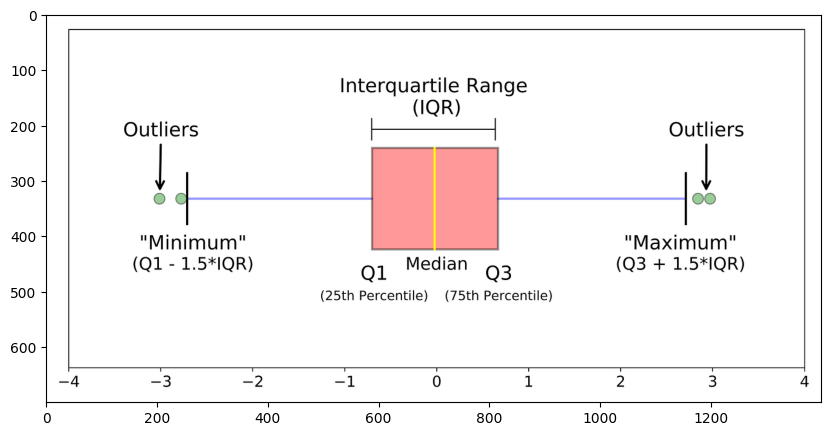

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('Documents/1_0MPDTLn8KoLApoFvI0P2vQ.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

<div class="alert alert-warning">
    
### English    
**What is IQR?**

Measures the spread of the middle 50% of data.  
Calculated as the difference between the third quartile (Q3) and the first quartile (Q1).  

**Identifying Outliers with IQR**

Outliers are data points that fall outside of the range [Q1 - 1.5IQR, Q3 + 1.5IQR].  
This method focuses on the central portion of the data, making it robust against extreme values.  

**Why Use IQR?** 

Effective in skewed distributions, unlike mean and standard deviation.  
Helps in cleaning data for accurate statistical analysis and modeling.  

**Limitations**

The 1.5*IQR threshold is somewhat arbitrary and may not suit every dataset.  
Requires careful consideration of the dataset's context.

### German

**Was ist IQR?**

Misst die Streuung der mittleren 50% der Daten.  
Berechnet als Differenz zwischen dem dritten Quartil (Q3) und dem ersten Quartil (Q1).  

**Ausreißer mit IQR identifizieren**

Ausreißer sind Datenpunkte, die außerhalb des Bereichs [Q1 - 1.5IQR, Q3 + 1.5IQR] fallen.  
Diese Methode konzentriert sich auf den zentralen Teil der Daten, was sie robust gegenüber extremen Werten macht.  

**Warum IQR verwenden?** 

Wirksam bei schiefen Verteilungen, im Gegensatz zu Mittelwert und Standardabweichung.  
Hilft, Daten für eine genaue statistische Analyse und Modellierung zu bereinigen.  

**Einschränkungen**

Die Schwelle von 1.5*IQR ist etwas willkürlich und passt möglicherweise nicht zu jedem Datensatz.  
Erfordert eine sorgfältige Berücksichtigung des Kontexts des Datensatzes.

</div>


### Boxplot  and Violin plot

<div class="alert alert-warning">
     ### English 

Violin plots are more informative regarding the distribution and are best for detailed analysis, especially for large and complex datasets. \
Box plots are more straightforward and better for a clear, concise summary of the data, particularly useful for comparing multiple distributions and identifying outli
r### Germanon**

Violinendiagramme sind aussagekräftiger bezüglich der Verteilung und eignen sich am besten für eine detaillierte Analyse, insbesondere bei großen und komplexen Datensätzen. \
Boxplots sind unkomplizierter und besser für eine klare, prägnante Zusammenfassung der Daten geeignet, besonders nützlich zum Vergleichen mehrerer Verteilungen und zum Identifizieren von Ausreißern.

</div>
/div>


In [72]:
def show_boxplots(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        plt.figure(figsize=(15, 8))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

In [23]:
import warnings
warnings.filterwarnings('ignore')

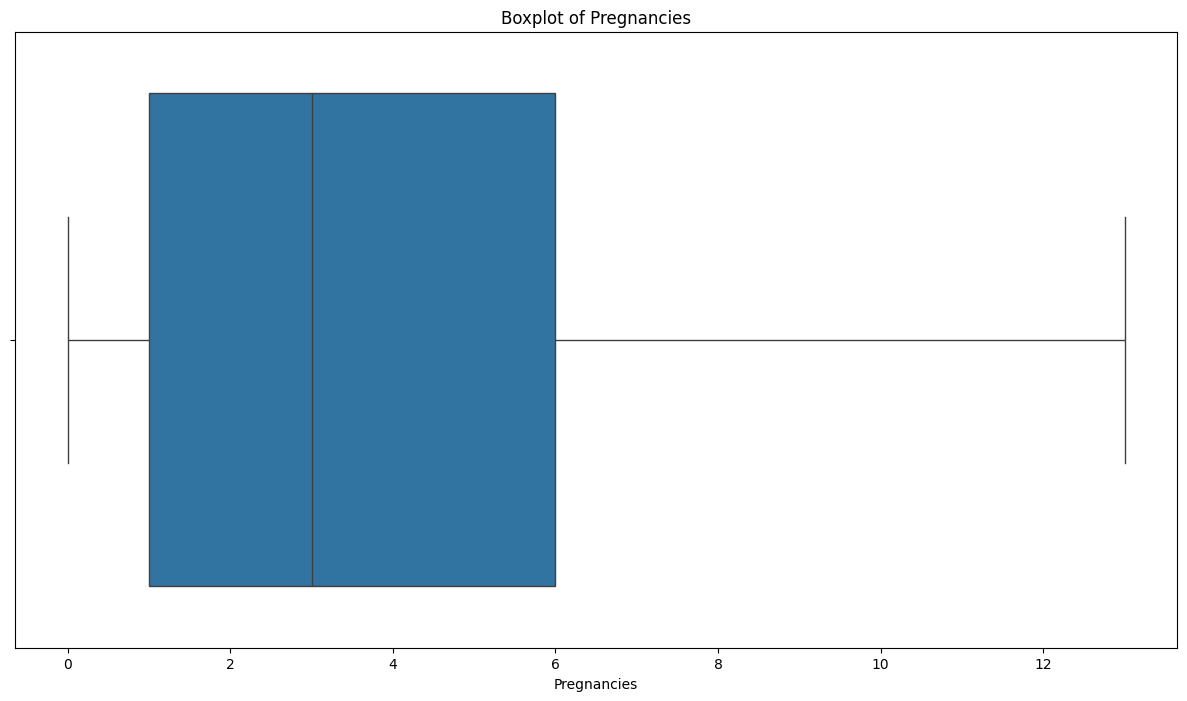

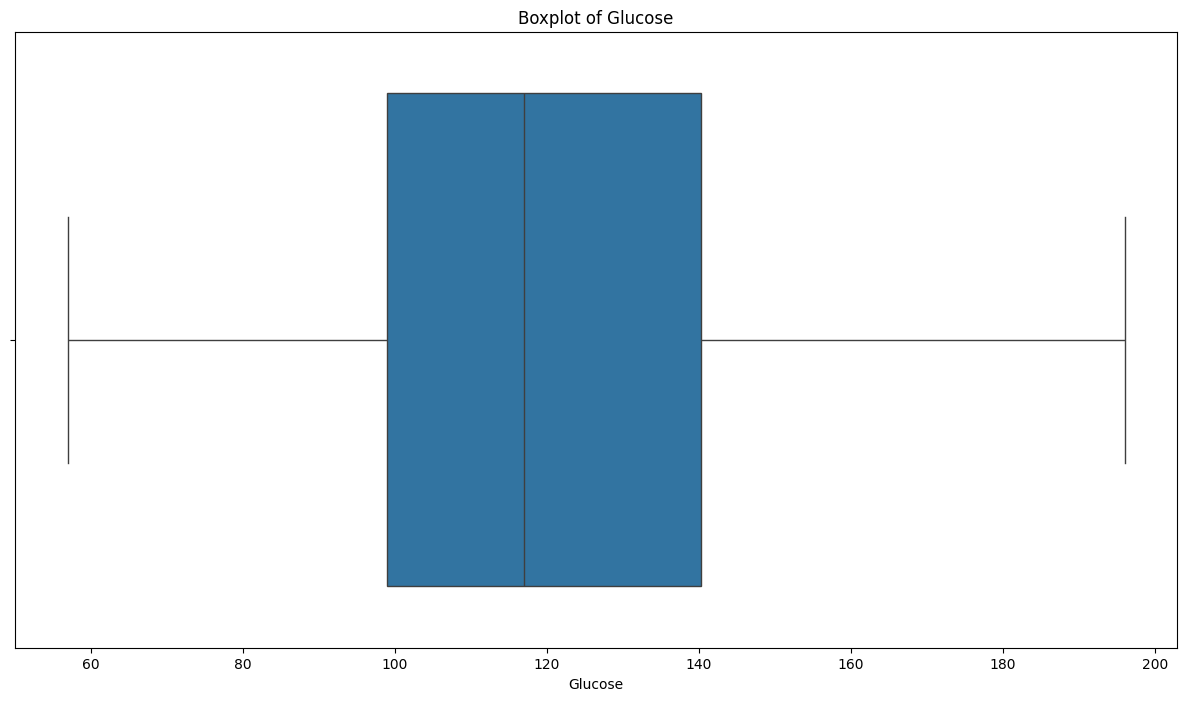

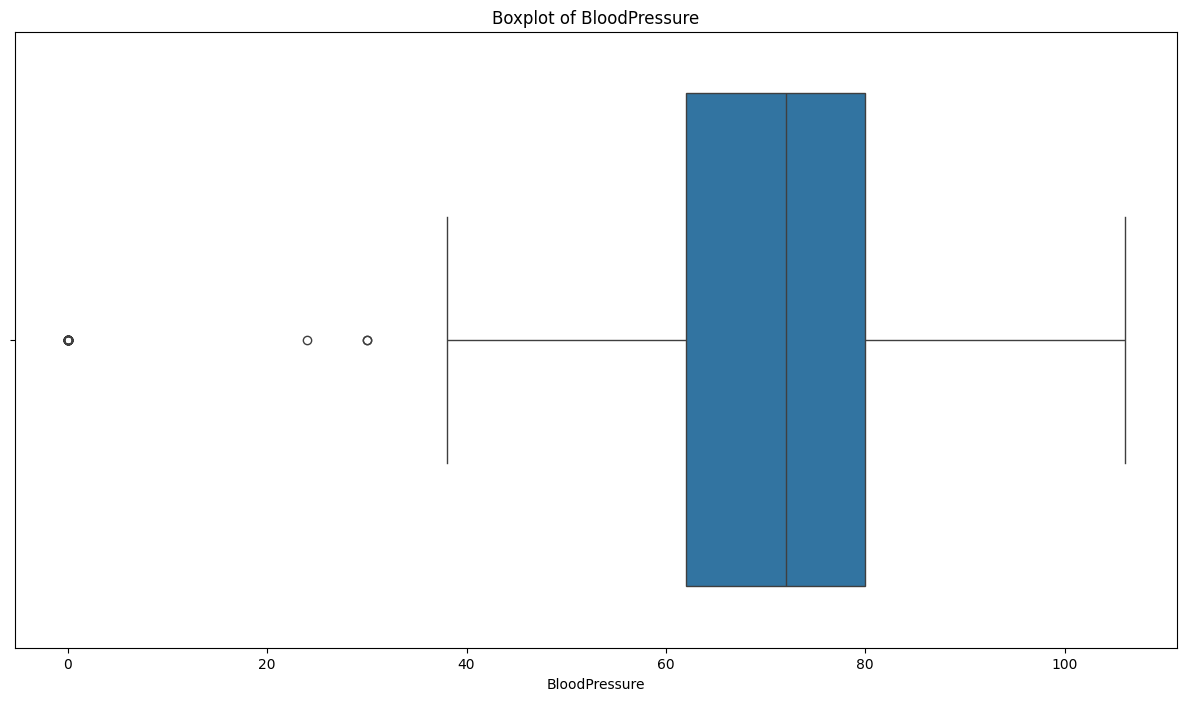

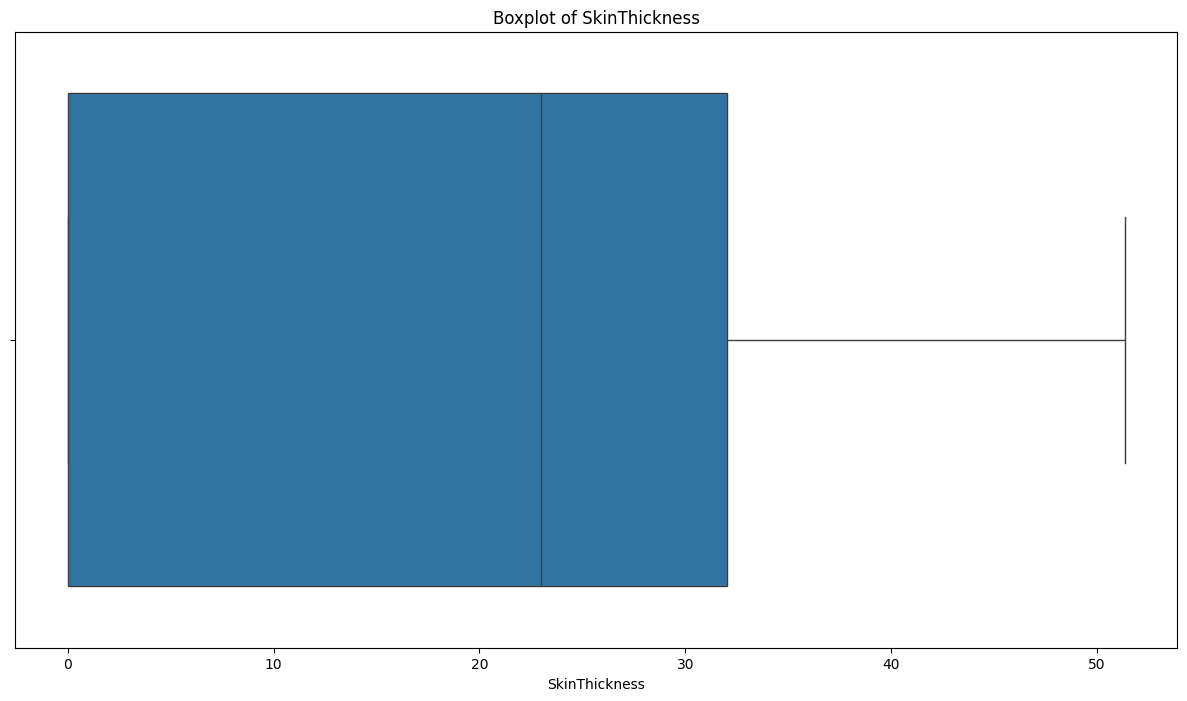

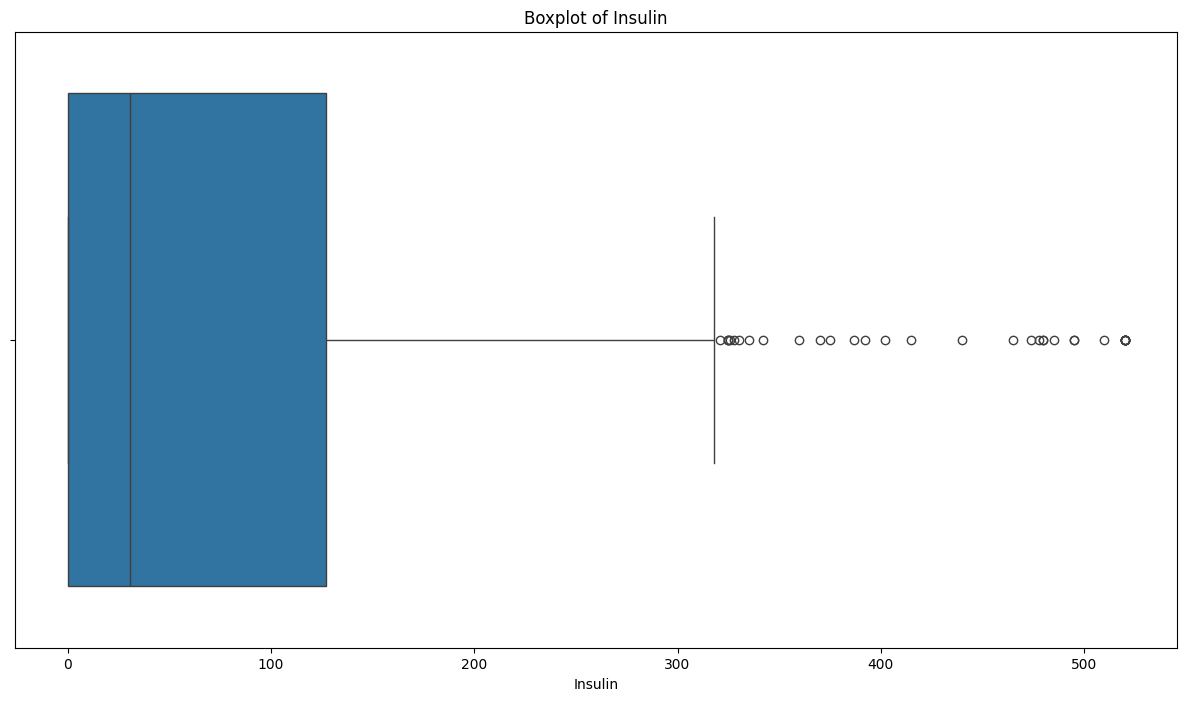

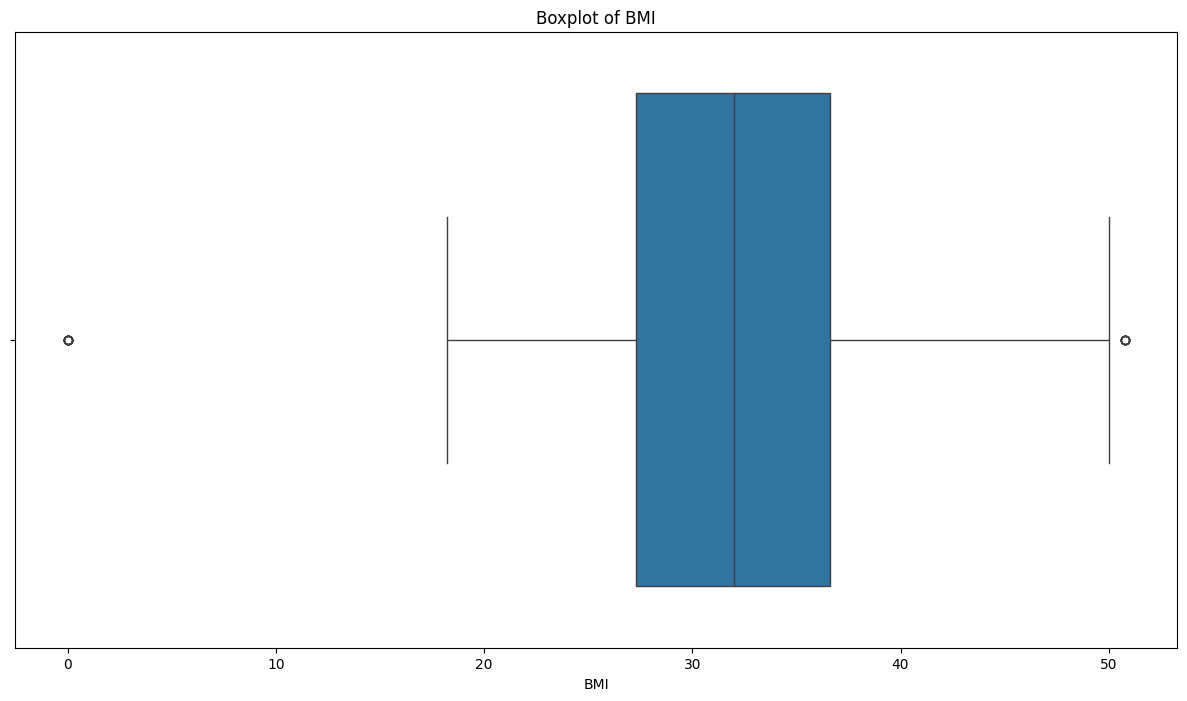

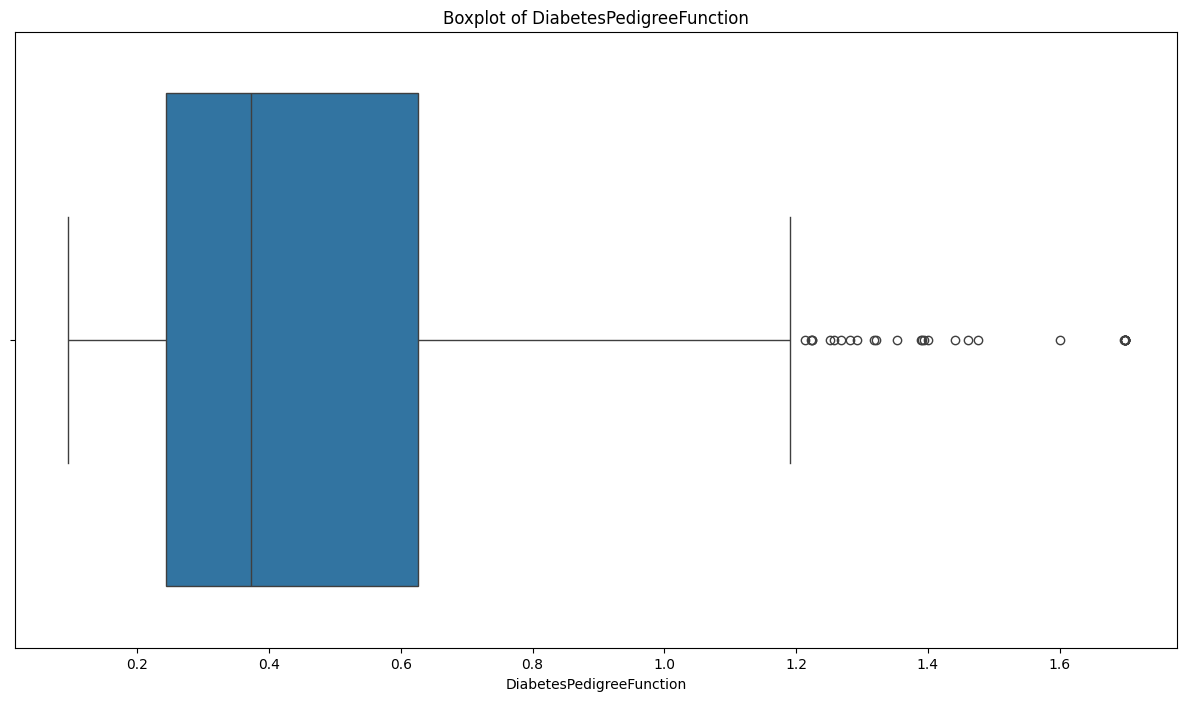

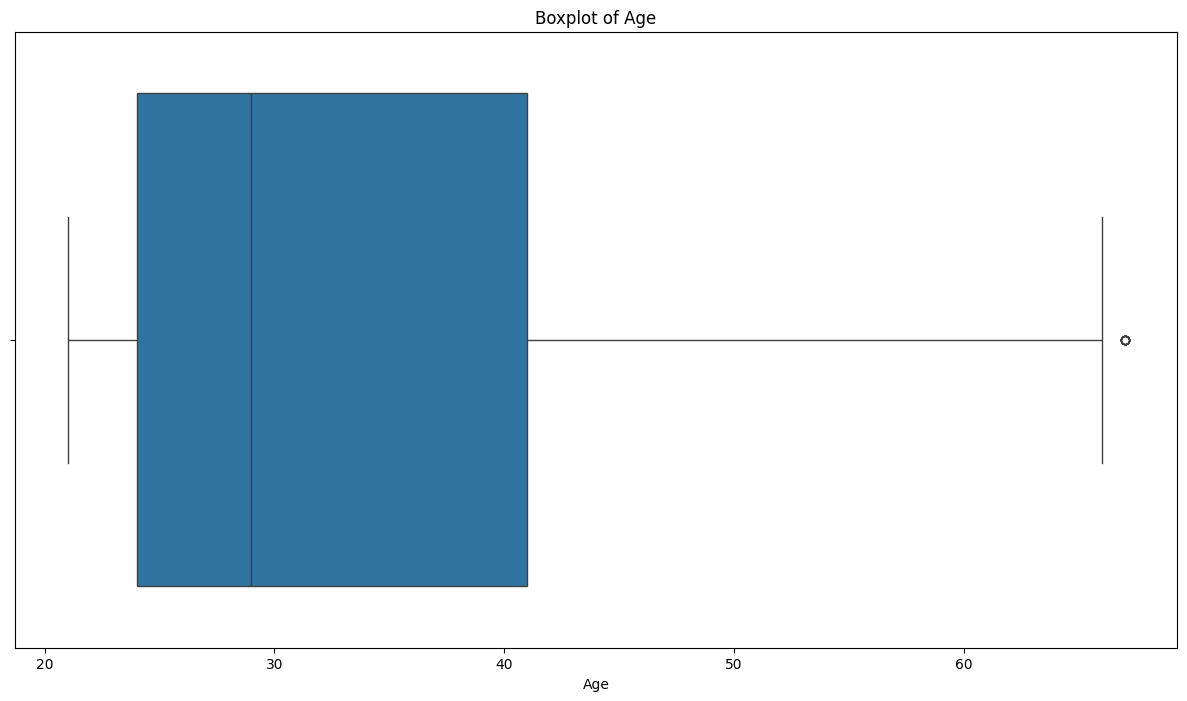

In [73]:
show_boxplots(df[numerical_columns])

## Histogram 

Another method is a histogram

In [74]:


def show_histograms(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        plt.figure(figsize=(15, 6))
        sns.histplot(df[col], kde=True, edgecolor='k', color='skyblue')
        mean_val = df[col].mean()
        median_val = df[col].median()
        plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
        
        plt.title(f'Histogram of {col} with KDE')
        plt.legend()
        plt.show()


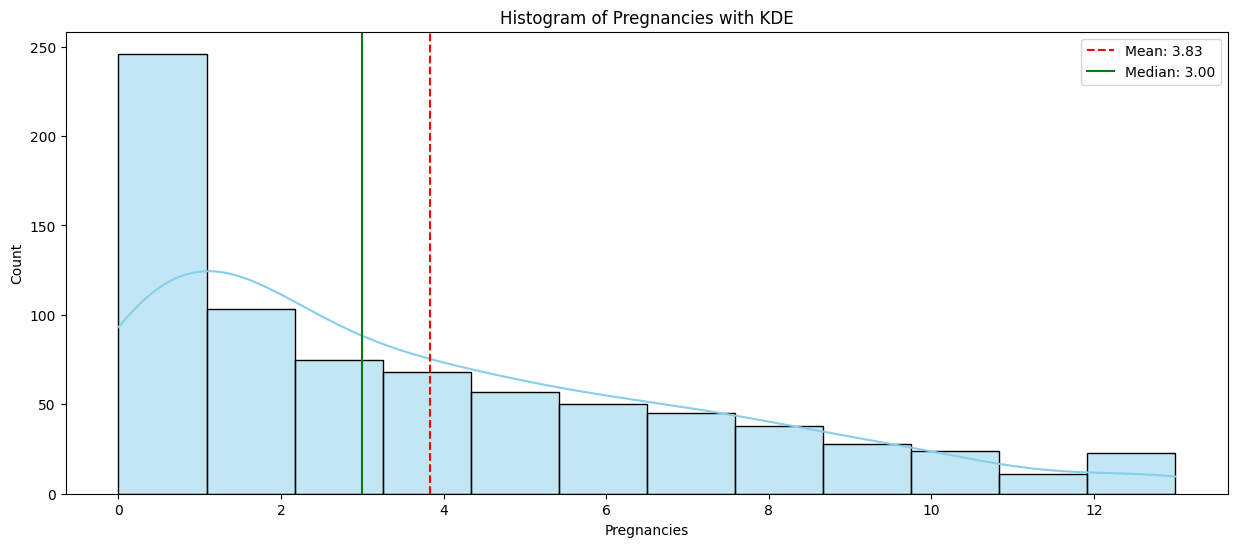

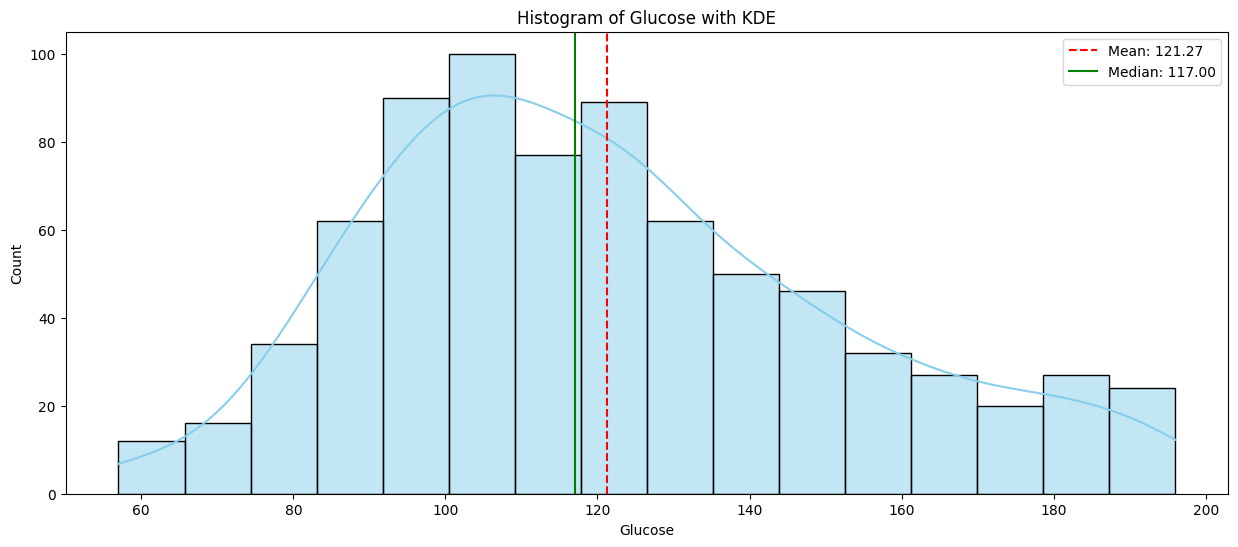

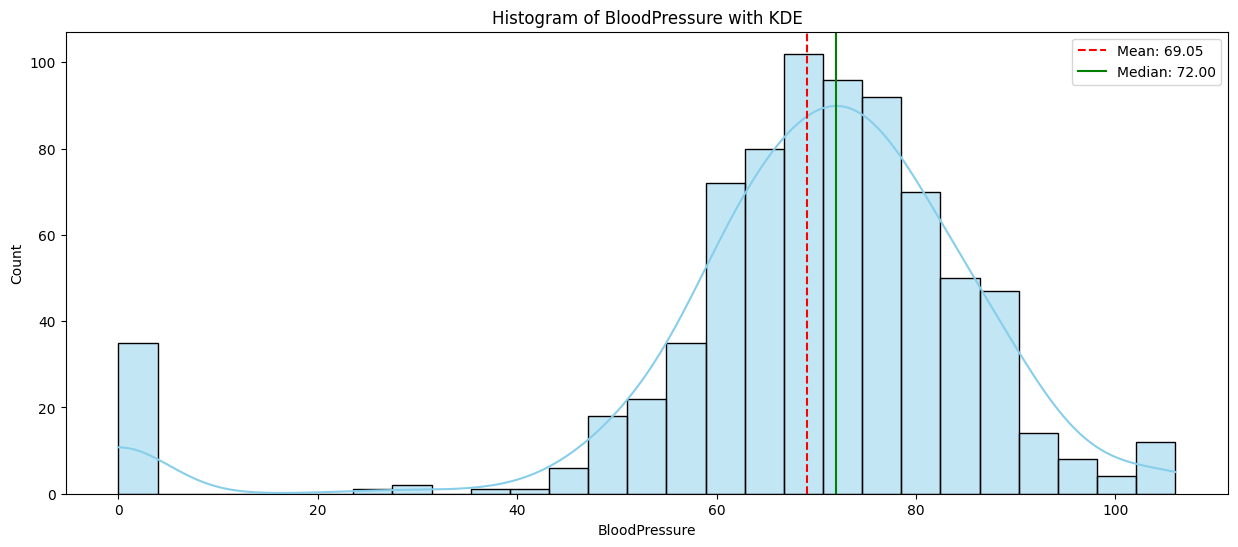

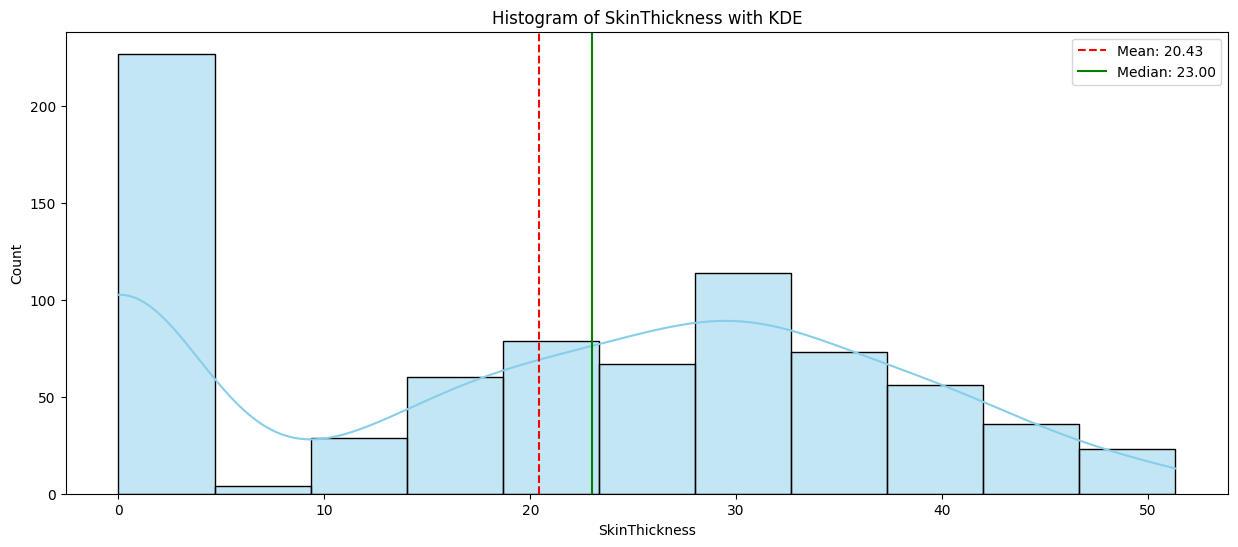

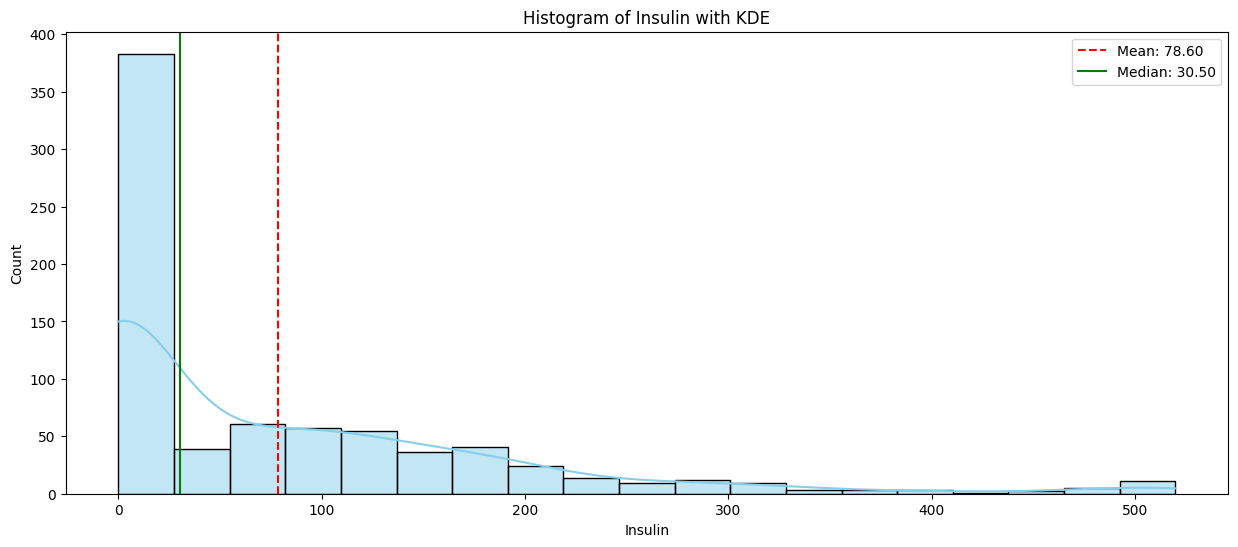

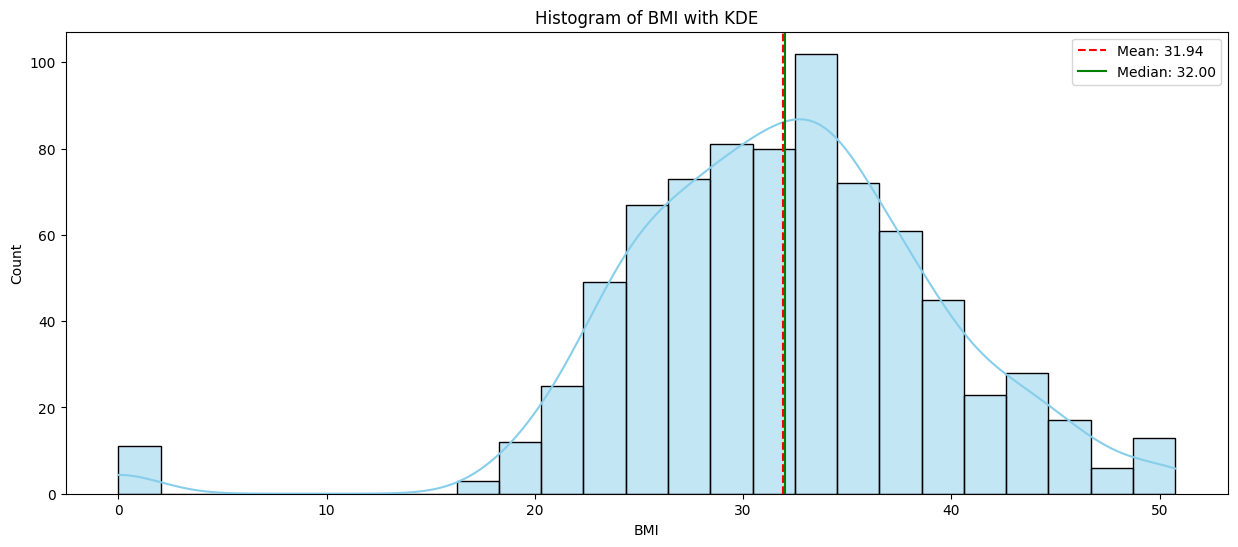

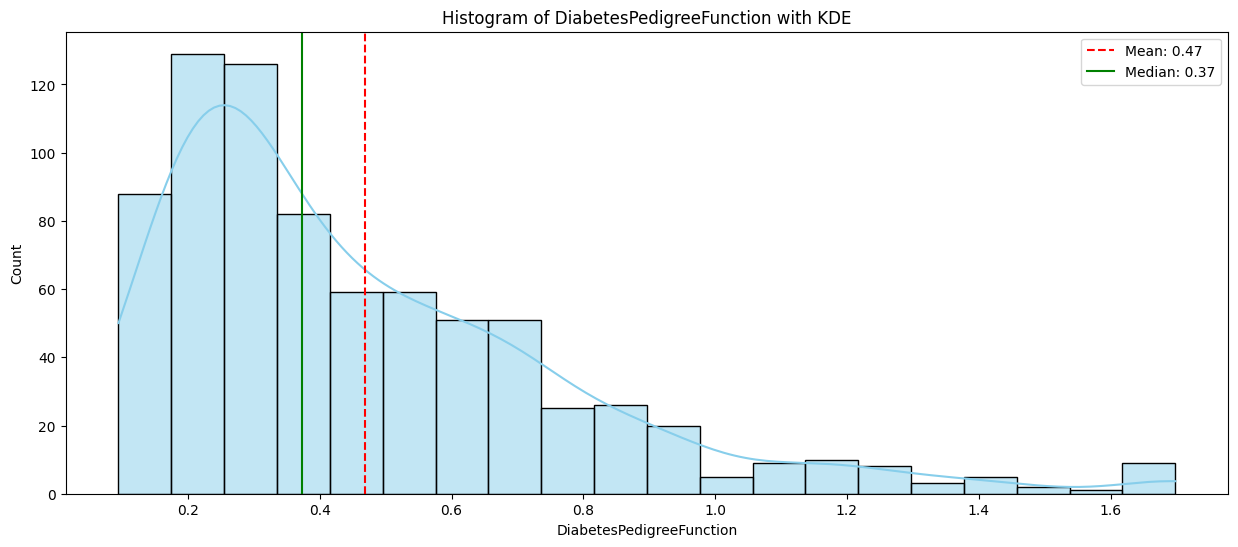

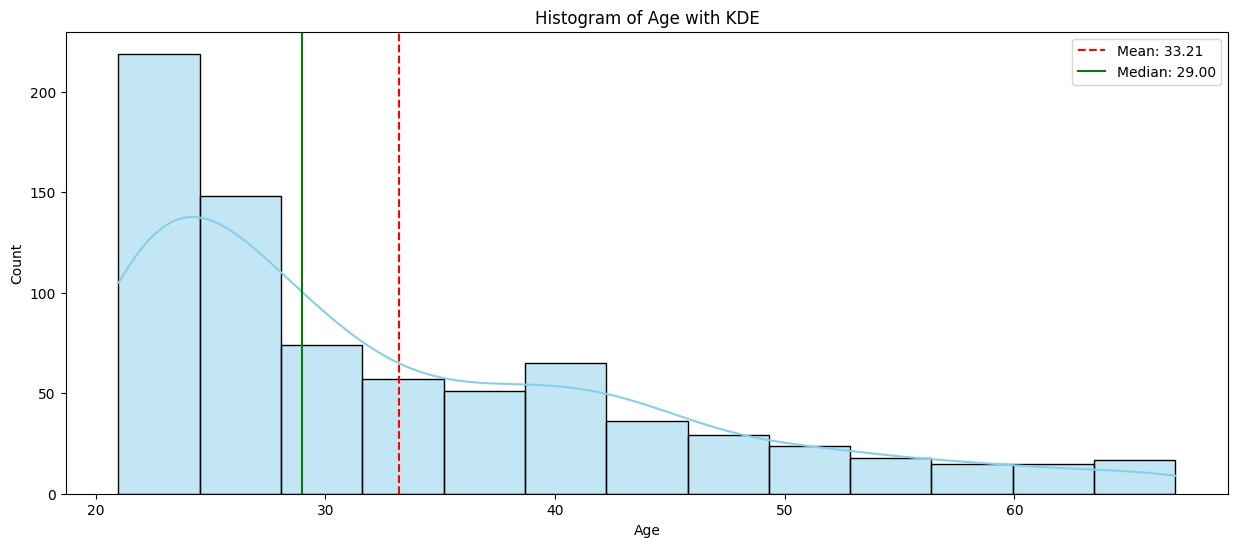

In [75]:
show_histograms(df[numerical_columns])

<div class="alert alert-success">
    
### English
Do you see any correlation between outliers in the boxplot, mean, and median in the histogram?

### Deutsch
Sehen Sie eine Korrelation zwischen Ausreißern im Boxplot, Mittelwert und Median im Histogramm?

</div>


### Dropping the columns with outliers

In [27]:
def find_outlier_columns(df, q1_value, q2_value):
    """
    Identify columns in the DataFrame that contain outliers.

    :param df: A pandas DataFrame.
    :return: A list of column names that have outliers.
    """
    outlier_columns = []
    numerical_cols = df.select_dtypes(include=['number']).columns
    # q1_value=0.25
    # q2_value=0.75
    for col in numerical_cols:
        Q1 = df[col].quantile(q1_value)
        Q3 = df[col].quantile(q2_value)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if ((df[col] < lower_bound) | (df[col] > upper_bound)).any():
            outlier_columns.append(col)
    return outlier_columns

In [28]:
find_outlier_columns(df[numerical_columns], 0.25, 0.75)

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

<div class="alert alert-warning">
    
### English
In industrial data analysis, especially with time series datasets, careful consideration is needed in identifying outliers. Not all points flagged as outliers are truly anomalous. A practical approach is to eliminate only the extreme outliers, using thresholds like the 0.01 and 0.99 quantiles. This method helps retain valuable data while removing the most improbable values, ensuring a more accurate and reliable analysis without overly distorting the dataset's natural variability.

### Deutsch
Bei der industriellen Datenanalyse, insbesondere bei Zeitreihendatensätzen, ist bei der Identifizierung von Ausreißern Vorsicht geboten. Nicht alle als Ausreißer markierten Punkte sind wirklich anomal. Ein praktischer Ansatz besteht darin, nur die extremen Ausreißer zu eliminieren, indem Schwellenwerte wie die 0,01 und 0,99 Quantile verwendet werden. Diese Methode hilft, wertvolle Daten zu bewahren, während die unwahrscheinlichsten Werte entfernt werden, und gewährleistet eine genauere und zuverlässigere Analyse, ohne die natürliche Variabilität des Datensatzes übermäßig zu verzerren.

</div>


<div class="alert alert-success">
    
### English
What problems could arise if you delete all of the outliers?

### Deutsch
Welche Probleme könnten entstehen, wenn Sie alle Ausreißer löschen?

</div>


In [29]:
find_outlier_columns(df[numerical_columns], 0.05, 0.95)

['Insulin']

In [30]:
def replace_outliers_with_limits(df, lower_quantile=0.01, upper_quantile=0.99):
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        lower_limit = df[col].quantile(lower_quantile)
        upper_limit = df[col].quantile(upper_quantile)
        
        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    return df

In [31]:
df=replace_outliers_with_limits(df)

In [32]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.0,0.0,33.6,0.62700,50,1
1,1,85,66,29.0,0.0,26.6,0.35100,31,0
2,8,183,64,0.0,0.0,23.3,0.67200,32,1
3,1,89,66,23.0,94.0,28.1,0.16700,21,0
4,0,137,40,35.0,168.0,43.1,1.69833,33,1


In [33]:
find_outlier_columns(df[numerical_columns], 0.05, 0.95)

[]

# Time to practice part 1 

 ## Step 4 Model training and  prediction

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


###  Splitting Dataset into Training and Test Sets

In [35]:

X = df.drop('Outcome', axis=1)
y = df[["Outcome"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)

In [36]:
column_names=X_train.columns

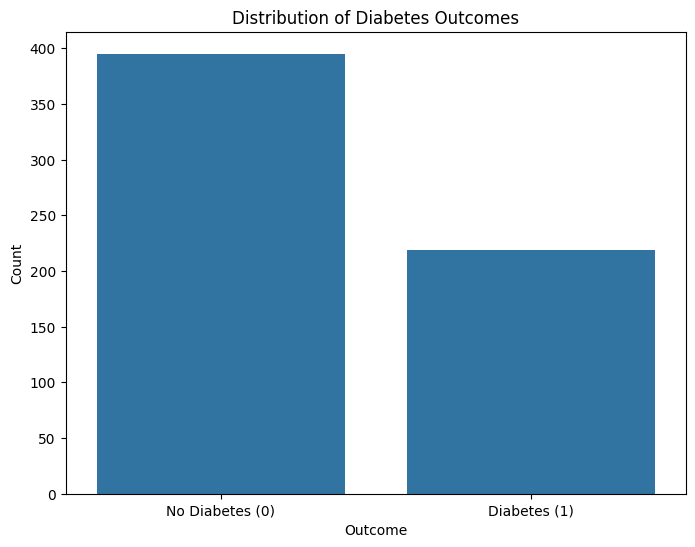

In [37]:
outcome_counts = y_train['Outcome'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

<div class="alert alert-warning">
    
### English
Synthetic Data Generation:

SMOTE (Synthetic Minority Over-sampling Technique): This method generates synthetic data for the minority class.

### Deutsch
Generierung synthetischer Daten:

SMOTE (Synthetische Minderheiten-Überabtastungstechnik): Diese Methode erzeugt synth


In [38]:
print(X_train.shape)
print(y_train.shape)

(614, 8)
(614, 1)


In [39]:
#pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

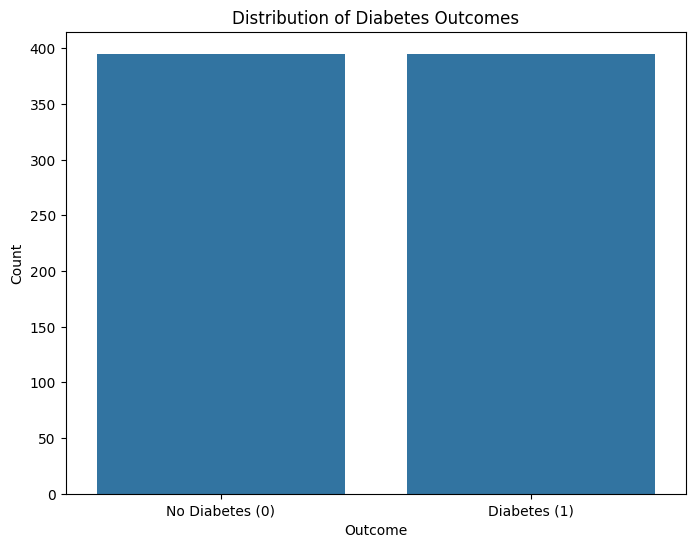

In [40]:
outcome_counts = y_train['Outcome'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

If you want to view the differences, deactivate these lines of code and compare the results

### Very important

<div class="alert alert-warning">
    
### English
Applying SMOTE (Synthetic Minority Over-sampling Technique) only to the training data and not to the test data is a crucial aspect of maintaining the validity of your model evaluation.

### Deutsch
Die Anwendung von SMOTE (Synthetische Minderheiten-Überabtastungstechnik) nur auf die Trainingsdaten und nicht auf die Testdaten ist ein entscheidender Aspekt, um die Gültigkeit Ihrer Modellbewertung zu erhalten.

</div>


In [41]:
print(X_train.shape)
print(y_train.shape)

(790, 8)
(790, 1)


### Scaling

In [42]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Hyperparameter Tuning Using GridSearchCV

In [43]:
param_grid = {
    'C': [0.001, 0.011, 0.01, 0.03, 0.05, 0.1,  0.2, 0.5,1, 10, 100, 500, 1000],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.1, 'penalty': 'l2'}


<div class="alert alert-warning">
    
### English
- The model is learning the patterns that might arise from the order in which the data was collected or organized. To solve this problem, shuffling the data or techniques like L1 or L2 regularization, which add a penalty to the loss function to discourage complex models, could be used.

### Deutsch
- Das Modell lernt die Muster, die sich aus der Reihenfolge ergeben können, in der die Daten gesammelt oder organisiert wurden. Um dieses Problem zu lösen, könnte das Mischen der Daten oder Techniken wie L1- oder L2-Regularisierung verwendet werden, die eine Strafe zur Verlustfunktion hinzufügen, um komplexe Modelle zu entmutigen.

</div>


In [44]:
#Create 10 numbers
mu = grid_search.best_params_['C']
sigma = 0.05
n = 10
random_numbers = np.random.normal(mu, sigma, n)
random_numbers

array([0.13395309, 0.11831949, 0.03547172, 0.0875937 , 0.05479914,
       0.06537332, 0.10626987, 0.04113401, 0.19364619, 0.1465659 ])

In [45]:
param_grid = {
    'C': random_numbers,
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.10626987321617314, 'penalty': 'l2'}


# Time to practice  part 2 

### Model Evaluation on Training Set

In [46]:
y_pred_train = best_lr.predict(X_train)
test_scores = {
    'accuracy': accuracy_score(y_train, y_pred_train),
    'precision': precision_score(y_train, y_pred_train),
    'recall': recall_score(y_train, y_pred_train),
    'f1': f1_score(y_train, y_pred_train),
    'roc_auc': roc_auc_score(y_train, best_lr.predict_proba(X_train)[:, 1])
}
print("\nTrain Set Evaluation Metrics:")
for metric, score in test_scores.items():
    print(f"{metric.capitalize()}: {score:.4f}")


Train Set Evaluation Metrics:
Accuracy: 0.7418
Precision: 0.7588
Recall: 0.7089
F1: 0.7330
Roc_auc: 0.8452


### Using the Cross validation 

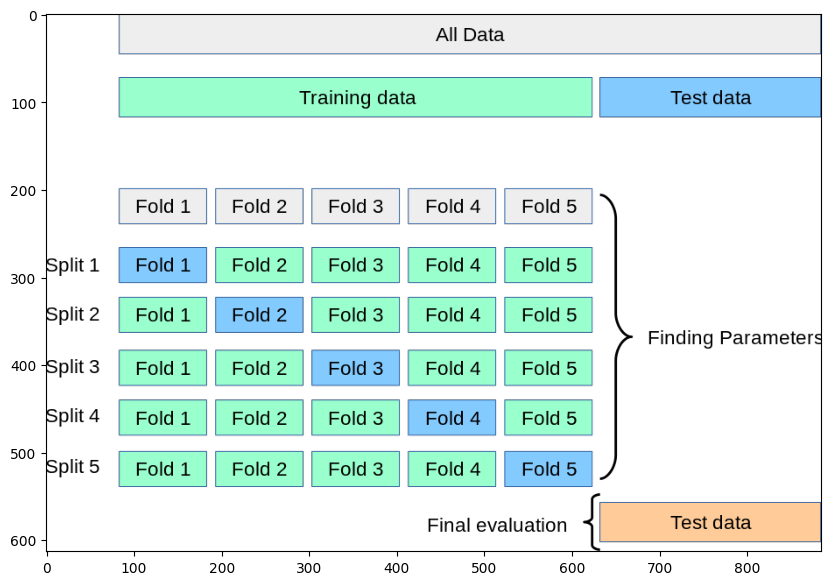

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('Documents/grid_search_cross_validation.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [48]:
train_scores = {
    'accuracy': cross_val_score(best_lr, X_train, y_train, cv=5, scoring='accuracy').mean(),
    'precision': cross_val_score(best_lr, X_train, y_train, cv=5, scoring='precision').mean(),
    'recall': cross_val_score(best_lr, X_train, y_train, cv=5, scoring='recall').mean(),
    'f1': cross_val_score(best_lr, X_train, y_train, cv=5, scoring='f1').mean(),
    'roc_auc': cross_val_score(best_lr, X_train, y_train, cv=5, scoring='roc_auc').mean()
}
print("Training Set Evaluation Metrics:")
for metric, score in train_scores.items():
    print(f"{metric.capitalize()}: {score:.4f}")


Training Set Evaluation Metrics:
Accuracy: 0.7380
Precision: 0.7559
Recall: 0.7063
F1: 0.7289
Roc_auc: 0.8373


### Final Model Evaluation on Test Set

In [49]:
y_pred = best_lr.predict(X_test)
test_scores = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, best_lr.predict_proba(X_test)[:, 1])
}
print("\nTest Set Evaluation Metrics:")
for metric, score in test_scores.items():
    print(f"{metric.capitalize()}: {score:.4f}")


Test Set Evaluation Metrics:
Accuracy: 0.7597
Precision: 0.5968
Recall: 0.7551
F1: 0.6667
Roc_auc: 0.8286


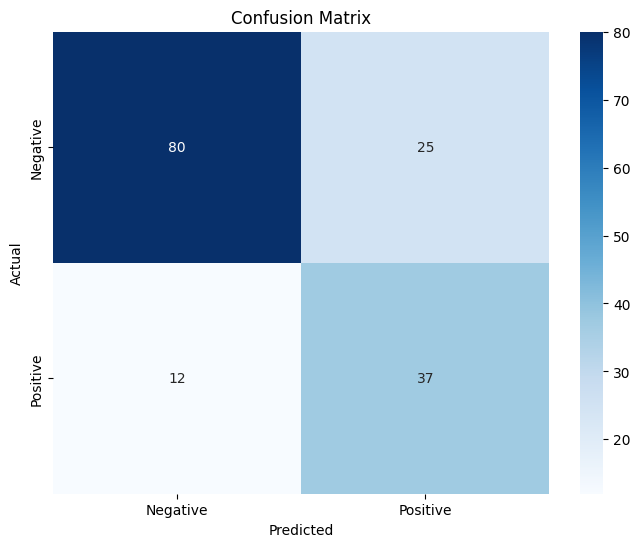

In [50]:
# Compute confusion matrix
cm_pred = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pred, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()       

The confusion matrix shows that our model gave a positive prediction; however, the actual value is negative. Therefore, we need to decrease the number of positive values.

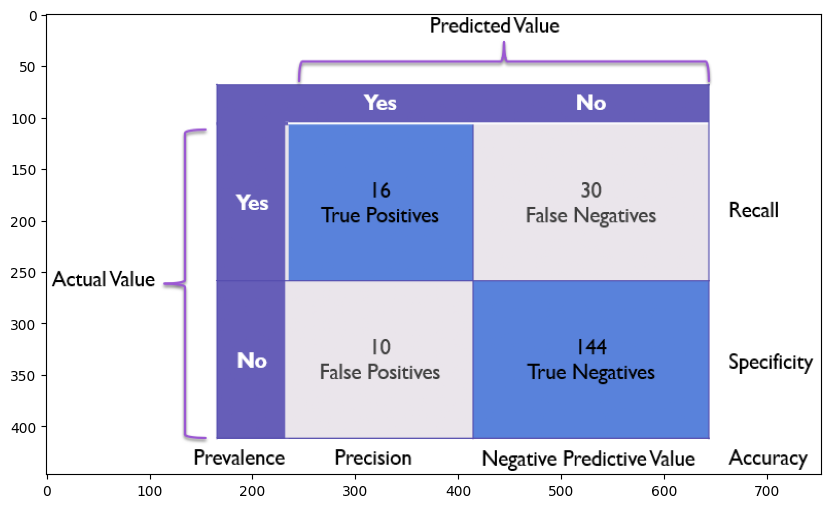

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('Documents/ConfusionAll.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [52]:
probabilities = best_lr.predict_proba(X_test)

In [53]:
prob_df_ = pd.DataFrame(probabilities, columns=['Prediction_0', 'Prediction_1'])


filtered_df = prob_df_[(prob_df_['Prediction_1'] > 0.5) & (prob_df_['Prediction_1'] < 0.6)]

filtered_df.head()

,Prediction_0,Prediction_1
18,0.491962,0.508038
19,0.447409,0.552591
32,0.495870,0.504130
47,0.475600,0.524400
62,0.495047,0.504953


In [54]:
y_pred = best_lr.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
y_pred_df.iloc[filtered_df.index].head()

,Prediction
18,1
19,1
32,1
47,1
62,1


In [55]:
new_threshold = 0.6
probabilities = best_lr.predict_proba(X_test)[:, 1] # Probabilities for the positive class
new_predictions = (probabilities >= new_threshold).astype(int)
print(classification_report(y_test, new_predictions))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.67      0.65      0.66        49

    accuracy                           0.79       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.78      0.79      0.79       154



In [56]:
new_prediction = pd.DataFrame(new_predictions, columns=['Prediction'])
new_prediction.iloc[filtered_df.index].head()

,Prediction
18,0
19,0
32,0
47,0
62,0


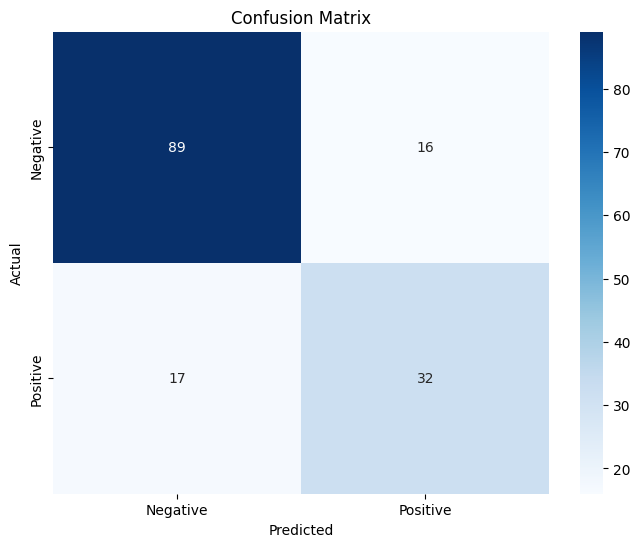

In [57]:

cm_pred_ = confusion_matrix(y_test, new_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pred_, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [58]:
cm_pred_

array([[89, 16],
       [17, 32]], dtype=int64)

### Receiver Operating Characteristic (ROC) Curve'

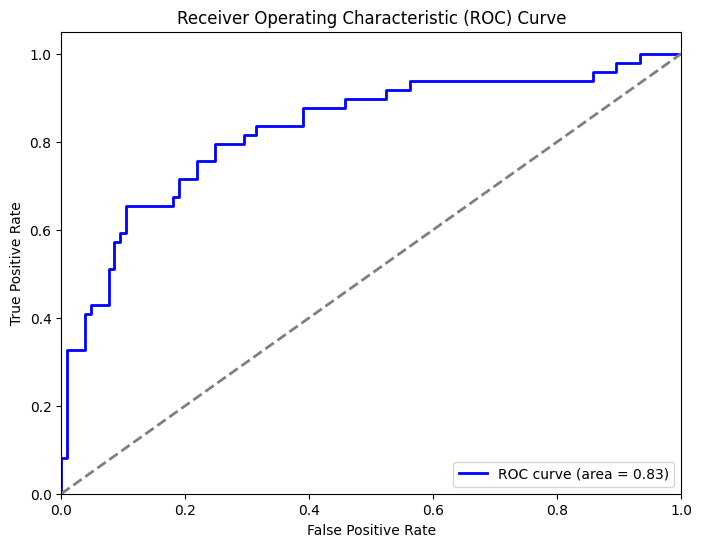

In [59]:
y_pred_proba = best_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
def plot_roc_curve(model, X, y, label=None):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')

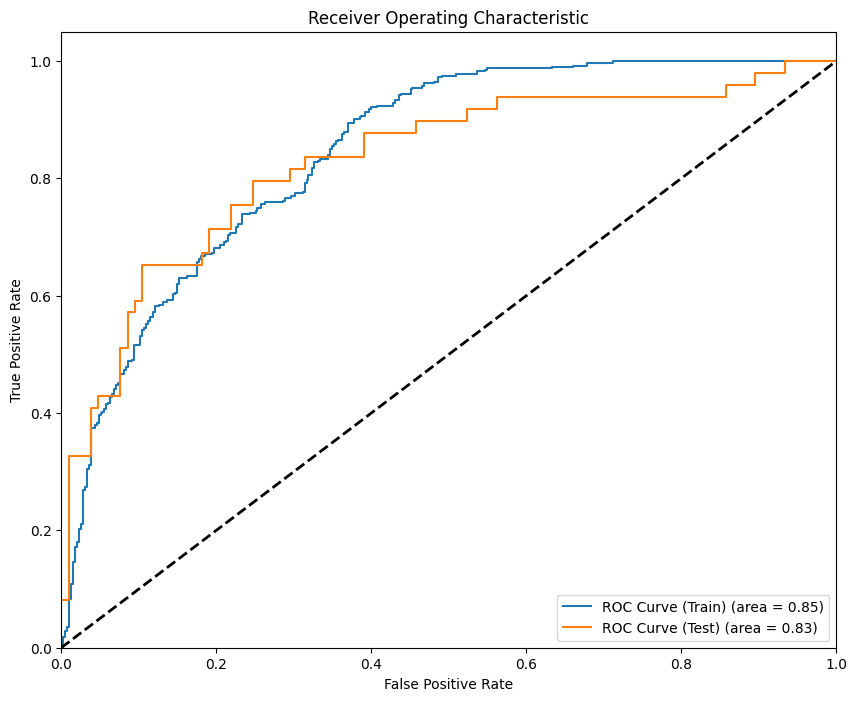

In [61]:
plt.figure(figsize=(10, 8))
plot_roc_curve(best_lr, X_train, y_train, 'ROC Curve (Train)')
plot_roc_curve(best_lr, X_test, y_test, 'ROC Curve (Test)')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right");

### Feature importance 

In [62]:
 ## Feature importance can be understood by looking at the coefficients assigned to each feature.

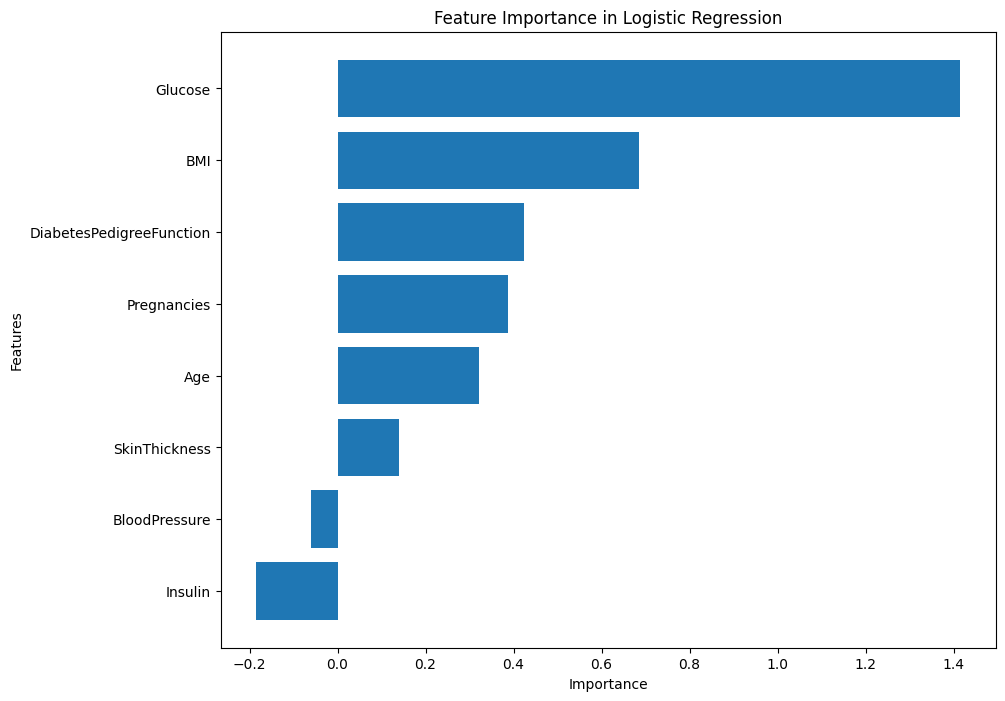

In [63]:
feature_names = column_names
coefficients = best_lr.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()


The coefficients represent the weights assigned to each feature after the logistic regression model has been fitted\
The magnitude of the coefficient (regardless of the sign) indicates the importance of the feature in the model. \
A large negative coefficient means that the feature is an important predictor of the target variable, but it has an inverse relationship. 

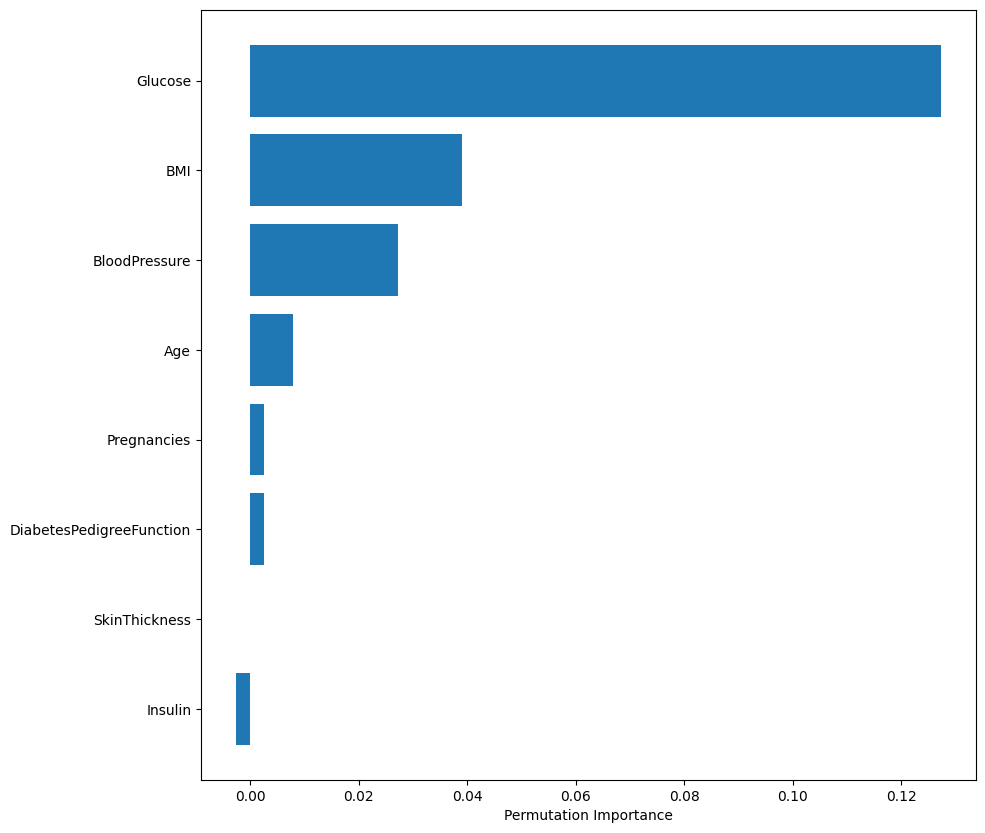

In [64]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_lr, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

<div class="alert alert-warning">

### English
**Positive Values:** A feature with a positive permutation importance value suggests that when the values of this feature are randomly shuffled, it doesn't significantly change the model's performance. This indicates that the information contained in this feature is important for making predictions. The model relies on the actual values of this feature to some degree.

**Negative Values:** Conversely, a feature with a negative permutation importance value indicates that when the values of this feature are shuffled, it leads to significant fluctuations in the model's performance. This suggests that the specific values of the feature may not be as important as their order or pattern. Negative values can be a sign of overfitting, redundancy with other features, or noise in the dataset. The model might perform better when the feature's relationship with the target outcome is disrupted. The feature may not be useful and possibly even detrimental to the model, as the model performs better when the feature's relationship with the outcome is broken. The feature could be redundant with other features, meaning that its contribution is not unique, and the model can rely on other features for the prediction. There could be noise in the dataset, or the way the permutation importance is calculated does not align well with the feature's actual relationship with the target variable.

### Deutsch
**Positive Werte:** Ein Merkmal mit einem positiven Permutationswichtigkeitswert deutet darauf hin, dass, wenn die Werte dieses Merkmals zufällig gemischt werden, dies die Leistung des Modells nicht signifikant verändert. Dies zeigt an, dass die in diesem Merkmal enthaltenen Informationen wichtig für die Vorhersage sind. Das Modell verlässt sich bis zu einem gewissen Grad auf die tatsächlichen Werte dieses Merkmals.

**Negative Werte:** Umgekehrt deutet ein Merkmal mit einem negativen Permutationswichtigkeitswert darauf hin, dass, wenn die Werte dieses Merkmals gemischt werden, dies zu signifikanten Schwankungen in der Leistung des Modells führt. Dies legt nahe, dass die spezifischen Werte des Merkmals möglicherweise nicht so wichtig sind wie ihre Ordnung oder ihr Muster. Negative Werte können ein Zeichen von Überanpassung, Redundanz mit anderen Merkmalen oder Rauschen im Datensatz sein. Das Modell könnte besser abschneiden, wenn die Beziehung des Merkmals zum Zielergebnis gestört ist. Das Merkmal ist möglicherweise nicht nützlich und sogar schädlich für das Modell, da das Modell besser abschneidet, wenn die Beziehung des Merkmals zum Ergebnis unterbrochen ist. Das Merkmal könnte redundant mit anderen Merkmalen sein, was bedeutet, dass sein Beitrag nicht einzigartig ist und das Modell sich auf andere Merkmale für die Vorhersage verlassen kann. Es könnte Rauschen im Datensatz geben, oder die Art und Weise, wie die Permutationswichtigkeit berechnet wird, passt nicht gut zur tatsächlichen Beziehung des Merkmals zur Zielvariablen.

</div>


### Save the model

In [65]:
from sklearn.pipeline import Pipeline
import joblib

In [66]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', best_lr)
])
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'LogisticRegression.pkl')


['LogisticRegression.pkl']

In [67]:
diabetes_data = {
    'Pregnancies': [0, 1, 10, 4, 5],
    'Glucose': [0, 85, 190, 150, 135],
    'BloodPressure': [0, 66, 74, 65, 60],
    'SkinThickness': [0.0, 29.0, 15.0, 32.0, 25.0],
    'Insulin': [0.0, 0.0, 0.0, 120.0, 150.0],
    'BMI': [0, 26.6, 35.2, 26.6, 37.1],
    'DiabetesPedigreeFunction': [0.0, 0.35100, 0.800, 0.210, 1.250],
    'Age': [0, 31, 51, 33, 46]
}
df_diabetes = pd.DataFrame(diabetes_data)
df_diabetes= scaler.fit_transform(df_diabetes)

In [68]:
loaded_pipeline = joblib.load('LogisticRegression.pkl')
predictions = loaded_pipeline.predict(df_diabetes)

In [69]:
predictions

array([0, 0, 1, 0, 1], dtype=int64)